<a name="top"></a>
<br/>
# Athletes photos classification

<br/>

Author: [Lucas Lherbier](https://www.linkedin.com/in/lucas-lherbier/).

Last update: June 8th, 2020.
<br/>

---
This notebook is part of an ongoing personal project: implement a Python server, as an application, allowing to classify pictures between famous athletes. To do it, I create a deep learning model to classify pictures.  
The classifier is developed with the [*Keras*](https://keras.io/) library.

---

### Imports

In [20]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import os, shutil, cv2, random
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import random as rd

import timeit
from datetime import datetime

tf.__version__

'2.2.0'

### Hyper-parameters

We specify the value of the hyper-parameters for our model. 

In [5]:
image_size = 200
image_width, image_height = image_size, image_size
nb_epochs = 40
batch_size = 20
test_size = 30

input_shape = (image_width, image_height, 3)

train_size = 350
val_size = 50

## Data extraction

Once the pictures dataset created from Google Images, we need to create the training, validation and test sets.  
The train folder should contain $n$ folders (for the moment 2) each containing images of the respective classes. 

<br>

<figure>
  <img src="https://miro.medium.com/max/1400/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg" alt="structure"  width=600>
  <figcaption> <small> Figure 1: the directory structure for a binary classification problem. Source <a href="https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720">[1]</a>. </small> </figcaption>
</figure>


In [8]:
sports_list = ['james', 'nadal'] # list of the athletes to be classified

base_dir = 'D:/Documents/sport' 

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

In [9]:
# Creathe the directories with the training and validation pictures
for i in sports_list:
    train_i_dir = os.path.join(train_dir, i)
    validation_i_dir = os.path.join(validation_dir, i)
    os.mkdir(train_i_dir)
    os.mkdir(validation_i_dir)

# Creathe the directories with the test pictures
os.mkdir(os.path.join(test_dir, 'test'))


train_l = rd.sample(range(440), train_size)
not_train = [i for i in range(440) if i not in train_l]
val_l = rd.sample(not_train, val_size)
test_l = [i for i in not_train if i not in val_l]
    
# Copy first the first images to train_i_dir
print('Copying images to train folder')
for i in sports_list:
    fnames = [str(i)+'({}).jpg'.format(j+1) for j in train_l]
    for fname in fnames:
        src = base_dir + '/' + str(i) + '/' + fname
        dst = base_dir + '/train/' +  str(i) + '/' + fname
        shutil.copyfile(src, dst)

# Copy other images to vadidation
print('Copying images to validation folder')
for i in sports_list:
    fnames = [str(i)+'({}).jpg'.format(j+1) for j in val_l]
    for fname in fnames:
        src = base_dir + '/' + str(i) + '/' + fname
        dst = base_dir + '/validation/' +  str(i) + '/' + fname
        shutil.copyfile(src, dst)
        
# Copy other images to test
print('Copying images to test folder')
for i in sports_list:
    fnames = [str(i)+'({}).jpg'.format(j+1) for j in test_l]
    for fname in fnames:
        src = base_dir + '/' + str(i) + '/' + fname
        dst = base_dir + '/test/test/' + fname
        shutil.copyfile(src, dst)

Copying images to train folder
Copying images to validation folder
Copying images to test folder


## Data visualization

It is interesting to visualize few photos of each possible class. The following cells represent 9 pictures of the athletes.

In [70]:
def plot_pictures(athlete):
    """ Plot 9 random pictures of the athetes """
    path = os.path.join(base_dir,athlete)
    fig=plt.figure(figsize=(13, 13))
    for i,filename in enumerate(rd.sample(os.listdir(path), 9)):
        img_array = mpimg.imread(os.path.join(path,filename)) # load image pixels
        fig.add_subplot(3,3, i + 1)
        plt.imshow(img_array)
    plt.show()

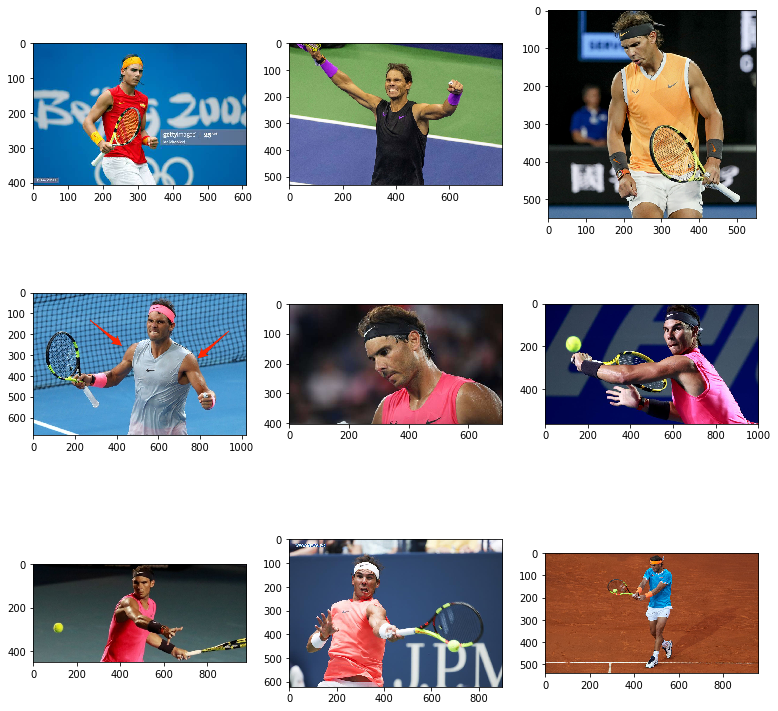

In [11]:
plot_pictures('nadal')

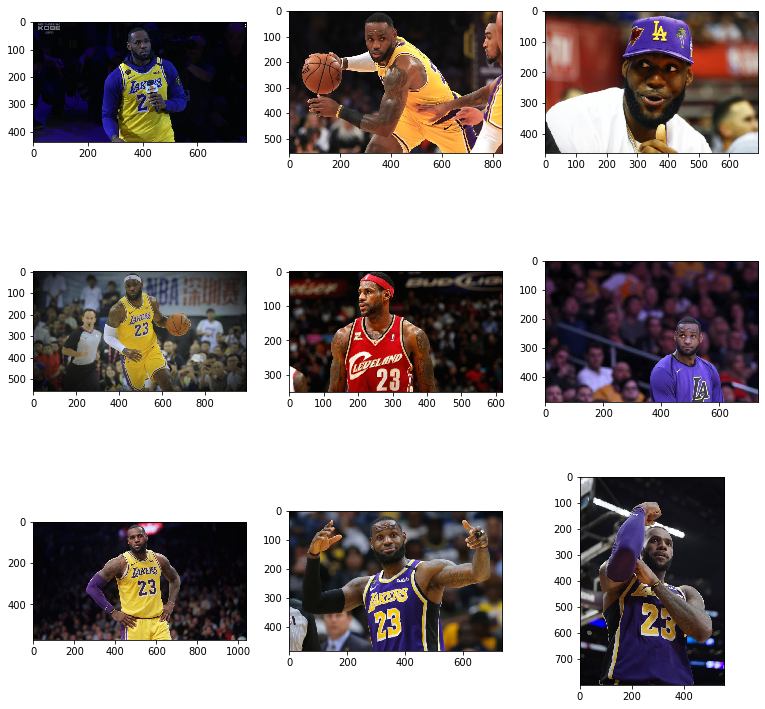

In [12]:
plot_pictures('james')

## Model

### Architecture

The deep learning model developed below uses convets. A [**convolutional neural network (CNN)**](https://en.wikipedia.org/wiki/Convolutional_neural_network) is a class of deep learning neural networks suited for analyzing visual imagery. I will not present you the theory about it because there are many good explanations available online, such as this [article](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).  

The convnet takes as input tensors of shape (image_height, image_width, image_channels) previously specified. The model is a stack of `Conv2D` and `MaxPooling2D` layers. Moreover, the 3D outputs are flattened to 1D, then fed into a densely-connected classifier network composed of a stack of `Dense` layers.


<br>

<figure>
  <img src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg" alt="structure"  width=700>
  <figcaption> <small> Figure 2: structure of a convolutional neural network. Source <a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">[2]</a>. </small> </figcaption>
</figure>


In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

To better understand how our model is built, we display its architecture.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Data processing

A neural network can only take as input figures and an image is nothing but a matrix of pixel values.
So, the data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. The pre-process is composed of several steps, such as decode the JPG content to RBG grids of pixels, convert these into floating point tensors or also rescale the pixel values ($[0, 255]$) to the $[0, 1]$ interval.

To do that, we use the class `ImageDataGenerator` from the Keras module `keras.preprocessing.image` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. 

In [78]:
# All images will be rescaled by 1./255
train_data_generator = ImageDataGenerator(rescale=1./255)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
        train_dir, # target directory
        target_size=(image_width, image_height), # resize the images
        batch_size= batch_size,
        class_mode='binary')

validation_generator = validation_data_generator.flow_from_directory(
        validation_dir, 
        target_size=(image_width, image_height), 
        batch_size= batch_size,
        class_mode='binary')

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=1,
    class_mode=None, 
    shuffle=None)

Found 700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 80 images belonging to 1 classes.


In [23]:
callback = [EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=2)]
history = model.fit(
      train_generator,
      steps_per_epoch= len(train_generator.filenames)//batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator.filenames)//batch_size,
      callbacks=callback)

model.save('james_vs_nadal_v1.h5')

Epoch 1/20
35/35 [==============================] - 71s 2s/step - loss: 0.6622 - acc: 0.6057 - val_loss: 0.5816 - val_acc: 0.7700
Epoch 2/20
35/35 [==============================] - 66s 2s/step - loss: 0.5563 - acc: 0.7229 - val_loss: 0.5546 - val_acc: 0.6700
Epoch 3/20
35/35 [==============================] - 71s 2s/step - loss: 0.4612 - acc: 0.7929 - val_loss: 0.4715 - val_acc: 0.8100
Epoch 4/20
35/35 [==============================] - 71s 2s/step - loss: 0.4193 - acc: 0.8057 - val_loss: 0.3851 - val_acc: 0.7900
Epoch 5/20
35/35 [==============================] - 73s 2s/step - loss: 0.3998 - acc: 0.8214 - val_loss: 0.4635 - val_acc: 0.7500
Epoch 00005: early stopping


## Results

### Training and validation curves

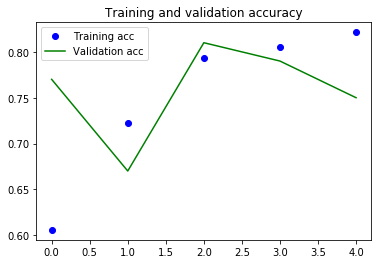

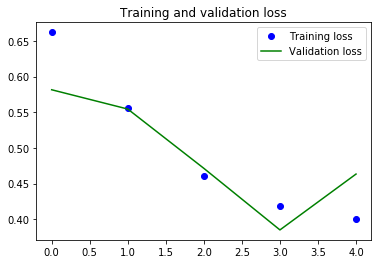

In [26]:
def plot_results_curves(res):
    """ Plot the training and validation curves for the accuracy metric and the loss """
    acc = res['acc']
    val_acc = res['val_acc']
    loss = res['loss']
    val_loss = res['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_results_curves(history.history)   

### Confusion matrix

In [48]:
def matrix_confusion(probabilities):
    """ Plot the confusion matrix """
    y_true = np.array([0] * 40 + [1] * 40)
    y_pred = probabilities > 0.5

    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sn.heatmap(cm.T, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['James', 'Nadal'])
    ax.yaxis.set_ticklabels(['James', 'Nadal'])

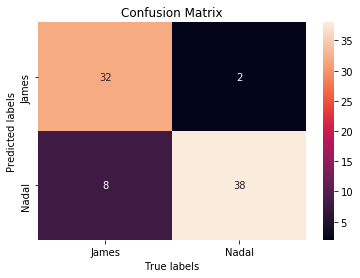

In [133]:
test_generator.reset()
proba = model.predict_generator(test_generator, 80)
matrix_confusion(proba)

### Test results visualization

To see if the model well generalize with unseen data, we use test pictures and visualize the results.

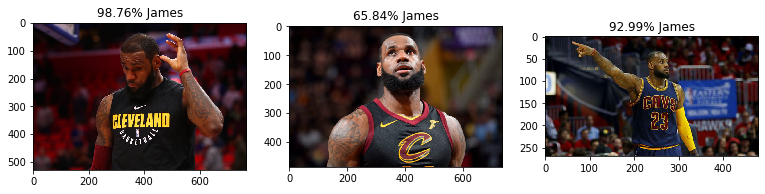

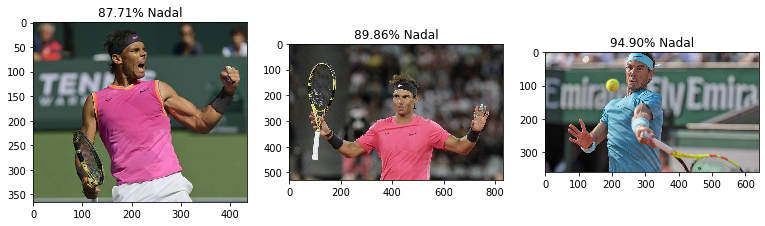

<Figure size 936x936 with 0 Axes>

In [134]:
def visualize_test_results(proba, test_generator):
    fig = plt.figure(figsize=(13, 13)) 
    index = 9
    for probability in proba[index+1:index+4]:
        image_path = test_dir + "/" + test_generator.filenames[index+1]
        img = mpimg.imread(image_path)
        ax = fig.add_subplot(1,3, index%3 + 1)
        ax.imshow(img)
        if probability >0.5:
            ax.title.set_text("%.2f" % (probability[0]*100) + "% Nadal")
        else:
            ax.title.set_text("%.2f" % ((1-probability[0])*100) + "% James")
        if index%3==2:
            plt.show()
            fig = plt.figure(figsize=(13, 13)) 
        index+=1
    index = 48
    for probability in proba[index+1:index+4]:
        image_path = test_dir + "/" + test_generator.filenames[index+1]
        img = mpimg.imread(image_path)
        ax = fig.add_subplot(1,3, index%3 + 1)
        ax.imshow(img)
        if probability >0.5:
            ax.title.set_text("%.2f" % (probability[0]*100) + "% Nadal")
        else:
            ax.title.set_text("%.2f" % ((1-probability[0])*100) + "% James")
        if index%3==2:
            plt.show()
            fig = plt.figure(figsize=(13, 13)) 
        index+=1
visualize_test_results(proba, test_generator)

# Data augmentation

## Presentation

We do not have a big pictures dataset for one specific reason. As it is created thanks to URL requests from Google Images, it needs daunting tasks of cleaning the wrong pictures: for examples, if some pictures contain Nadal and Federer, they have to be deleted. This is done handlly, then it is impossible to have some thousand pictures in our dataset.

However, we can use data augmentation: it is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images. By creating them via a number of random transformations that yield believable-looking images, it can improve the ability of the fit models to generalize.

The `ImageDataGenerator` instance configures a number of random transformations to be performed on the images.

In [112]:
datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.3,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

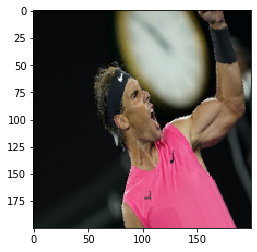

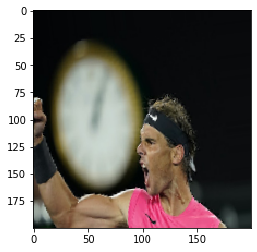

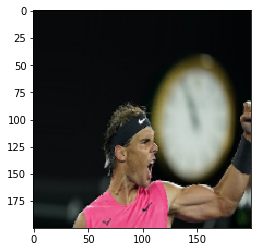

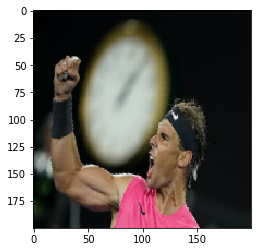

In [113]:
train_nadal_dir = os.path.join(train_dir, 'nadal')
fnames = [os.path.join(train_nadal_dir, fname) for fname in os.listdir(train_nadal_dir)]

img_path = fnames[rd.randint(0,440)] #choose one picture
img = image.load_img(img_path, target_size=(image_width, image_height))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1): # .flow() generates batches of randomly transformed images
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Model

In [31]:
model_augmented = models.Sequential()
model_augmented.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(image_width, image_height, 3)))
model_augmented.add(layers.MaxPooling2D((2, 2)))
model_augmented.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_augmented.add(layers.MaxPooling2D((2, 2)))
model_augmented.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_augmented.add(layers.MaxPooling2D((2, 2)))
model_augmented.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_augmented.add(layers.MaxPooling2D((2, 2)))
model_augmented.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_augmented.add(layers.MaxPooling2D((2, 2)))
model_augmented.add(layers.Flatten())
model_augmented.add(layers.Dropout(0.2))
model_augmented.add(layers.Dense(512, activation='relu'))
model_augmented.add(layers.Dense(1, activation='sigmoid'))

model_augmented.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [32]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_dir, # target directory
        target_size=(image_width, image_height), # resize the images
        batch_size= batch_size,
        class_mode='binary')

validation_generator_augmented = validation_data_generator.flow_from_directory(
        validation_dir,
        target_size=(image_width, image_height),
        batch_size= batch_size,
        class_mode='binary')

callback = [EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)]
history_augmented = model_augmented.fit(
      train_generator_augmented,
      steps_per_epoch= len(train_generator_augmented.filenames)//batch_size,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator_augmented.filenames)//batch_size,
      callbacks = callback)

model_augmented.save('james_vs_nadal_v2.h5')

Found 700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/20
35/35 [==============================] - 81s 2s/step - loss: 0.6780 - acc: 0.5700 - val_loss: 0.6680 - val_acc: 0.5300
Epoch 2/20
35/35 [==============================] - 80s 2s/step - loss: 0.5910 - acc: 0.7057 - val_loss: 0.5637 - val_acc: 0.7000
Epoch 3/20
35/35 [==============================] - 80s 2s/step - loss: 0.5279 - acc: 0.7343 - val_loss: 0.4342 - val_acc: 0.8500
Epoch 4/20
35/35 [==============================] - 83s 2s/step - loss: 0.4945 - acc: 0.7600 - val_loss: 0.4122 - val_acc: 0.8200
Epoch 5/20
35/35 [==============================] - 70s 2s/step - loss: 0.4290 - acc: 0.8086 - val_loss: 0.4523 - val_acc: 0.8100
Epoch 6/20
35/35 [==============================] - 71s 2s/step - loss: 0.4219 - acc: 0.8029 - val_loss: 0.3699 - val_acc: 0.8700
Epoch 7/20
35/35 [==============================] - 75s 2s/step - loss: 0.4078 - acc: 0.8229 - val_loss: 0.3727 - val_acc: 0.8100
Epoch 8/

## Results

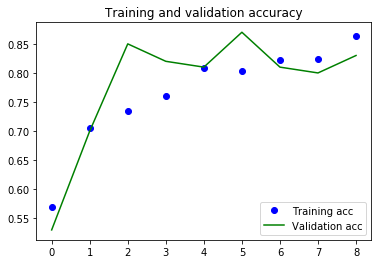

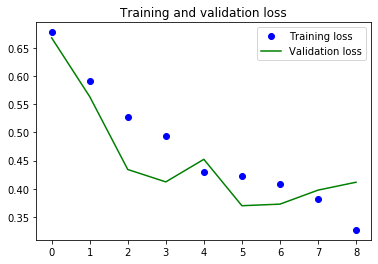

In [33]:
plot_results_curves(history_augmented.history)   

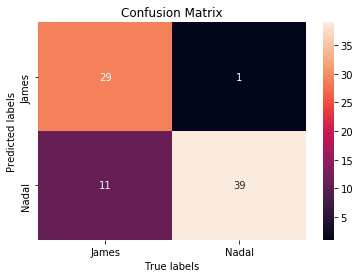

In [131]:
test_generator.reset()
probabilities = model_augmented.predict_generator(test_generator, 80)
matrix_confusion(probabilities)

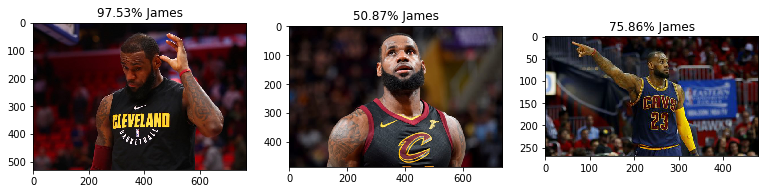

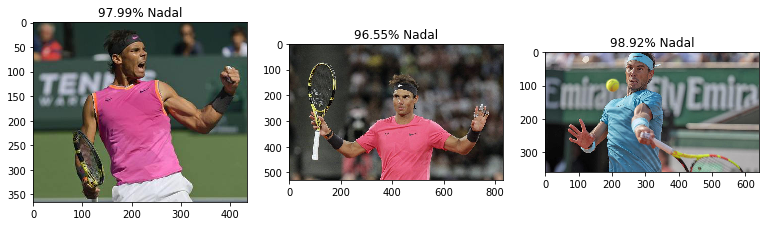

<Figure size 936x936 with 0 Axes>

In [132]:
visualize_test_results(probabilities, test_generator)

# Use of a pre-trained convnet

A common approach to train deep learning model with small image datasets is to use a pre-trained network, a saved network previously trained on a large dataset. And if this original dataset is general enough, the spatial feature hierarchy learned by the pre-trained network can act as a generic model and improve our model. 


## Convnet choice

In [35]:
from keras.applications import VGG16 

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

Using TensorFlow backend.


In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

## Feature extraction

We use the representations learned by the pre-trained network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.


<br>

<figure>
  <img src="https://camo.githubusercontent.com/2de162f6f3587a0422389355909594413ae17742/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f626f6f6b2e6b657261732e696f2f696d672f6368352f7377617070696e675f66635f636c61737369666965722e706e67" alt="structure"  width=600>
  <figcaption> <small> Figure 3: feature extraction process. Source  <u>Deep Learning with Python</u>, F.Chollet. </small> </figcaption>
</figure>

<br>

Now, we will run the convolutional base over our dataset, save the output to a Numpy array and then use this data as input to a densely-connected classifier. 

In [37]:
(size1, size2, size3) = conv_base.get_layer(index = -1).output_shape[1:]

def extract_features(directory, sample_count, batch_size = 10):
    features = np.zeros(shape=(sample_count, size1, size2, size3))
    labels = np.zeros(shape=(sample_count))
    generator = train_data_generator.flow_from_directory(
        directory,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, train_size*2)
validation_features, validation_labels = extract_features(validation_dir, val_size*2)
test_features, test_labels = extract_features(os.path.join(base_dir, 'test2'), 40*2, 1)

Found 700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


The extracted features goes to a densely-connected classifier, so we must flatten them.

In [43]:
train_features = np.reshape(train_features, ( 350 *2, size1*size2*size3))
validation_features = np.reshape(validation_features, (50 *2, size1*size2*size3))
test_features = np.reshape(test_features, (40 *2, size1*size2*size3))

In [59]:
model_pretrained = models.Sequential()
model_pretrained.add(layers.Dropout(0.3))
model_pretrained.add(layers.Dense(512, activation='relu', input_dim=size1*size2*size3))
model_pretrained.add(layers.Dense(1, activation='sigmoid'))

model_pretrained.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

callback = [EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)]
history = model_pretrained.fit(train_features, train_labels,
      steps_per_epoch= len(train_generator_augmented.filenames)//batch_size,
      epochs=20,
      validation_data=(validation_features, validation_labels),
      callbacks = callback)

model_pretrained.save('james_vs_nadal_v3.h5')

Epoch 1/20
35/35 [==============================] - 7s 199ms/step - loss: 0.5639 - acc: 0.7486 - val_loss: 0.3555 - val_acc: 0.8200
Epoch 2/20
35/35 [==============================] - 5s 133ms/step - loss: 0.2206 - acc: 0.9086 - val_loss: 0.2058 - val_acc: 0.9300
Epoch 3/20
35/35 [==============================] - 5s 133ms/step - loss: 0.2265 - acc: 0.9157 - val_loss: 0.1803 - val_acc: 0.9300
Epoch 4/20
35/35 [==============================] - 4s 128ms/step - loss: 0.1023 - acc: 0.9643 - val_loss: 1.3304 - val_acc: 0.5700
Epoch 5/20
35/35 [==============================] - 5s 135ms/step - loss: 0.0995 - acc: 0.9600 - val_loss: 0.1613 - val_acc: 0.9400
Epoch 6/20
35/35 [==============================] - 4s 128ms/step - loss: 0.0477 - acc: 0.9843 - val_loss: 0.5933 - val_acc: 0.8000
Epoch 7/20
35/35 [==============================] - 5s 131ms/step - loss: 0.0529 - acc: 0.9843 - val_loss: 0.2254 - val_acc: 0.9100
Epoch 8/20
35/35 [==============================] - 4s 127ms/step - loss: 0.

## Results

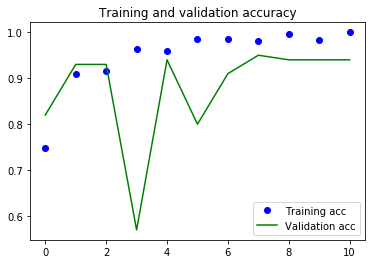

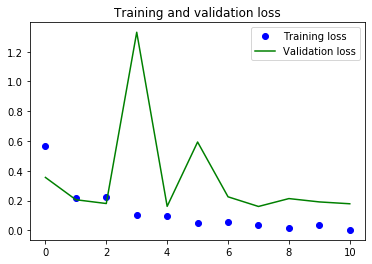

In [61]:
plot_results_curves(history.history)

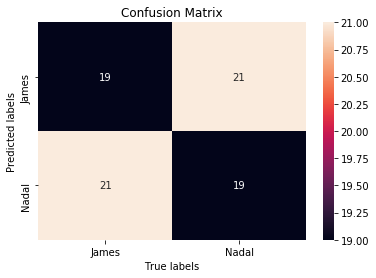

In [64]:
probabilities = model_pretrained.predict(test_features)
matrix_confusion(probabilities)

# Conclusion

## Summary 
In this notebook, I presented you my way of building a picture classifier. Specifically, my work was divided in several parts:
* loading the sportsmen pictures
* preparing the pictures for modelling
* creation of a convolutional neural network for picture classification from scratch
* use of data augmentation to "augment" our few training examples via a number of random transformations, so that our model would never see twice the exact same picture
* use of a network pre-trained on a large dataset


## Explanations of the results

By looking the different metrics, the best model are the orignial one and the one using data augmentation. We can notice with the confusion matrix that the accuracy for the test dataset are respectively 87.5% and 85%. I do not reach score around 0.95% as accuracy because of diverse reasons:
* the low number of pictures. I have only 880 pictures, 440 per class, which is not enough to train a well performed model.
* the quality of pictures. Usually, for the face recognition problem, we use identity photo with only the face such as in the following picture.
<figure>
  <img src="http://vintage.winklerbros.net/Images/facescrub.jpg" alt="structure"  width=auto>
  <figcaption> <small> Figure 4: example of face pictures. Source <a href="http://vintage.winklerbros.net/facescrub.html">[4]</a>. </small> </figcaption>
</figure>
<br>

* Here, we see that the color jersey of the athletes varies a lot, the light or also the face size in the picture. For example, if you look the below picture, we understand why it is too difficult for the algorithm to perfectly recognize the sportsmen.
    * on the first picture, Nadal wears a pink tee shirt and the background is 
    * on the second one, the ground is orange because it is clay and Nadal's jersey is yellow 
    * on the third one, he is doing an interview. The background is dark and he has a cap.
    
The deep learning models are based on RGB pixels, thus it is too hard to not confuse Nadal during an interview and James who always plays inside with dark background.

<br>

<figure>
  <img src="conclusion.png" alt="structure"  width=auto>
  <figcaption> <small> Figure 5: comparison between nadal pictures.</small> </figcaption>
</figure>

<br>


## Solutions to a further work

It is clear that if we want to improve the model performance, we have to find much more data and more focused on their face. In my work, I extracted personally the image dataset from Goole Images and then clean it, by deleting the pictures with other teammates or wrong athletes. This data pre-processing is time-consuming and it will be interesting to find an automatic way to do it. 

Now, I better understand why one said that data is the oil of machine learning problems.

Perhaps you have been wondering :
* *Why do not take other pictures (during interviews for example) ?* The problem is the same: there is not enough interview pictures available on the internet and the background or tee shirt colors vary a lot.
* *or other celebrities ?* Sport is my passion, so I wanted to work with athletes.

---
Back to [top](#top).